In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, classification_report

#ruta cambiada (ruta de yannis)
df = pd.read_csv("/content/drive/MyDrive/IA PROJECT 1/csv/CSV's genericos/train.csv")

PASOS EDA
1. inspeccion general (describe/head)
2. tipos de datos (cuantitativos o categoricos)
3. valores nulos (rellenar moda/media/mediana, knn, nada, rellenar con 0, eliminar variable si > x%, MICE o MLE) (de más a menos simple)
4. duplicados
5. inspección visual (distribuciones)
5. Balance de clases
6. outliers /valores atípicos (con gráficos p.ej boxplot)
7. correlaciones
8. transformación logartimica? (solo si estan las distribuciones altamente sesgadas)
8. Relaciones no lineales (LOWESS, GAM)
8. Multicolinealidad (VIF)
9. posible análisis multivariante (sexo y edad (>50?))


PREPARACIÓN ANTES DE SPLITS
1. feature engineering (posible creación de nuevas variables)
1. normalizar (z-score)
2. probar con y sin smote

CONCLUSIONES COMUNES ANTES DE ANÁLISIS DE DIMENSIONALIDAD (feature extraction o feature selection)

In [ ]:
#este codigo para cambiar el formato de los datos

df['age'] = df['age'].astype(int)
df['sex'] = df['sex'].astype(int)
df['cp'] = df['cp'].astype(int)
df['restecg'] = df['restecg'].astype(int)

object_cols = df.select_dtypes(include=['object']).columns
for col in object_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Comprobación
display(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       732 non-null    int64  
 1   sex       732 non-null    int64  
 2   cp        732 non-null    int64  
 3   trestbps  685 non-null    float64
 4   chol      727 non-null    float64
 5   fbs       674 non-null    float64
 6   restecg   732 non-null    int64  
 7   thalach   688 non-null    float64
 8   exang     688 non-null    float64
 9   oldpeak   683 non-null    float64
 10  slope     637 non-null    float64
 11  ca        483 non-null    float64
 12  thal      563 non-null    float64
 13  label     732 non-null    int64  
dtypes: float64(9), int64(5)
memory usage: 80.2 KB


None

In [ ]:
#Cambio de nombre de las columnas
df = df.rename(columns={
    "age": "edad",
    "sex": "sexo",
    "cp": "tipo_dolor_pecho",
    "trestbps": "tension_en_descanso",
    "chol": "colesterol",
    "fbs": "azucar",
    "restecg": "electro_en_descanso",
    "thalach": "latidos_por_minuto",
    "exang": "dolor_pecho_con_ejercicio",
    "oldpeak": "cambio_linea_corazon_ejercicio",
    "slope": "forma_linea_corazon_ejercicio",
    "ca": "num_venas_grandes",
    "thal": "estado_corazon_thal"
})

df.head()
df.isnull().sum()
porcentaje_null = df.isnull().mean() * 100
porcentaje_null


,0
edad,0.000000
sexo,0.000000
tipo_dolor_pecho,0.000000
tension_en_descanso,6.420765
colesterol,0.683060
azucar,7.923497
electro_en_descanso,0.000000
latidos_por_minuto,6.010929
dolor_pecho_con_ejercicio,6.010929
cambio_linea_corazon_ejercicio,6.693989


In [ ]:
#  revisamos que valores aparecen, para detectar si hay valores repetidos como  (−1, −999, 99999…)
cols_num = df.select_dtypes(include=['int64', 'float64']).columns

for col in cols_num:
    print(f"\nColumna: {col}")
    print(df[col].value_counts().head(10))

df[cols_num] = df[cols_num].replace(-9, np.nan)




Columna: edad
edad
54    38
58    36
56    34
57    33
59    29
55    29
52    29
51    27
53    27
62    26
Name: count, dtype: int64

Columna: sexo
sexo
1    578
0    154
Name: count, dtype: int64

Columna: tipo_dolor_pecho
tipo_dolor_pecho
4    391
3    168
2    138
1     35
Name: count, dtype: int64

Columna: tension_en_descanso
tension_en_descanso
120.0    109
130.0     88
140.0     78
110.0     44
150.0     42
160.0     41
125.0     24
135.0     17
128.0     15
115.0     14
Name: count, dtype: int64

Columna: colesterol
colesterol
 0.0      135
-9.0       16
 223.0      9
 254.0      8
 216.0      8
 204.0      7
 243.0      7
 282.0      7
 220.0      7
 230.0      7
Name: count, dtype: int64

Columna: azucar
azucar
 0.0    554
 1.0    112
-9.0      8
Name: count, dtype: int64

Columna: electro_en_descanso
electro_en_descanso
0    439
2    148
1    145
Name: count, dtype: int64

Columna: latidos_por_minuto
latidos_por_minuto
140.0    36
150.0    35
120.0    29
160.0    23
130.0

CORRECIÓN!!!

Hay variables categóricas que se han imputado por la mediana

Aunque puede funcionar correctamente (que es lo que parece), puede haber sido por estos motivos:
   - No se han generado valores fuera de rango

  - El modelo no ha sufrido por outilers

Luego para asegurar una imputación inicial --> categóricas == moda + cuantitativas == mediana


In [ ]:
# Variables cuantitativas
cuantitativas = [
    'tension_en_descanso',
    'colesterol',
    'latidos_por_minuto',
    'cambio_linea_corazon_ejercicio']

# Variables categóricas
categoricas = [
    'azucar',
    'dolor_pecho_con_ejercicio',
    'forma_linea_corazon_ejercicio',
    'num_venas_grandes',
    'estado_corazon_thal']


for col in cuantitativas:
    df[col] = df[col].where(df[col] != -9)  # no tocar -9
    df[col] = df[col].fillna(df[col].median())

for col in categoricas:
    moda = df.loc[df[col] != -9, col].mode()[0]  # moda sin contar -9
    df[col] = df[col].where(df[col] != -9)      # no tocar -9
    df[col] = df[col].fillna(moda)

Colesterol y tension valores 0 son imposibles, requiere más preprocesado
(he guardado el csv)

In [ ]:
#Buscamos duplicados
df.duplicated().sum()
df = df.drop_duplicates()


In [ ]:
import os
df.to_csv('/content/drive/MyDrive/IA PROJECT 1/df_preprocesado.csv', index=False)

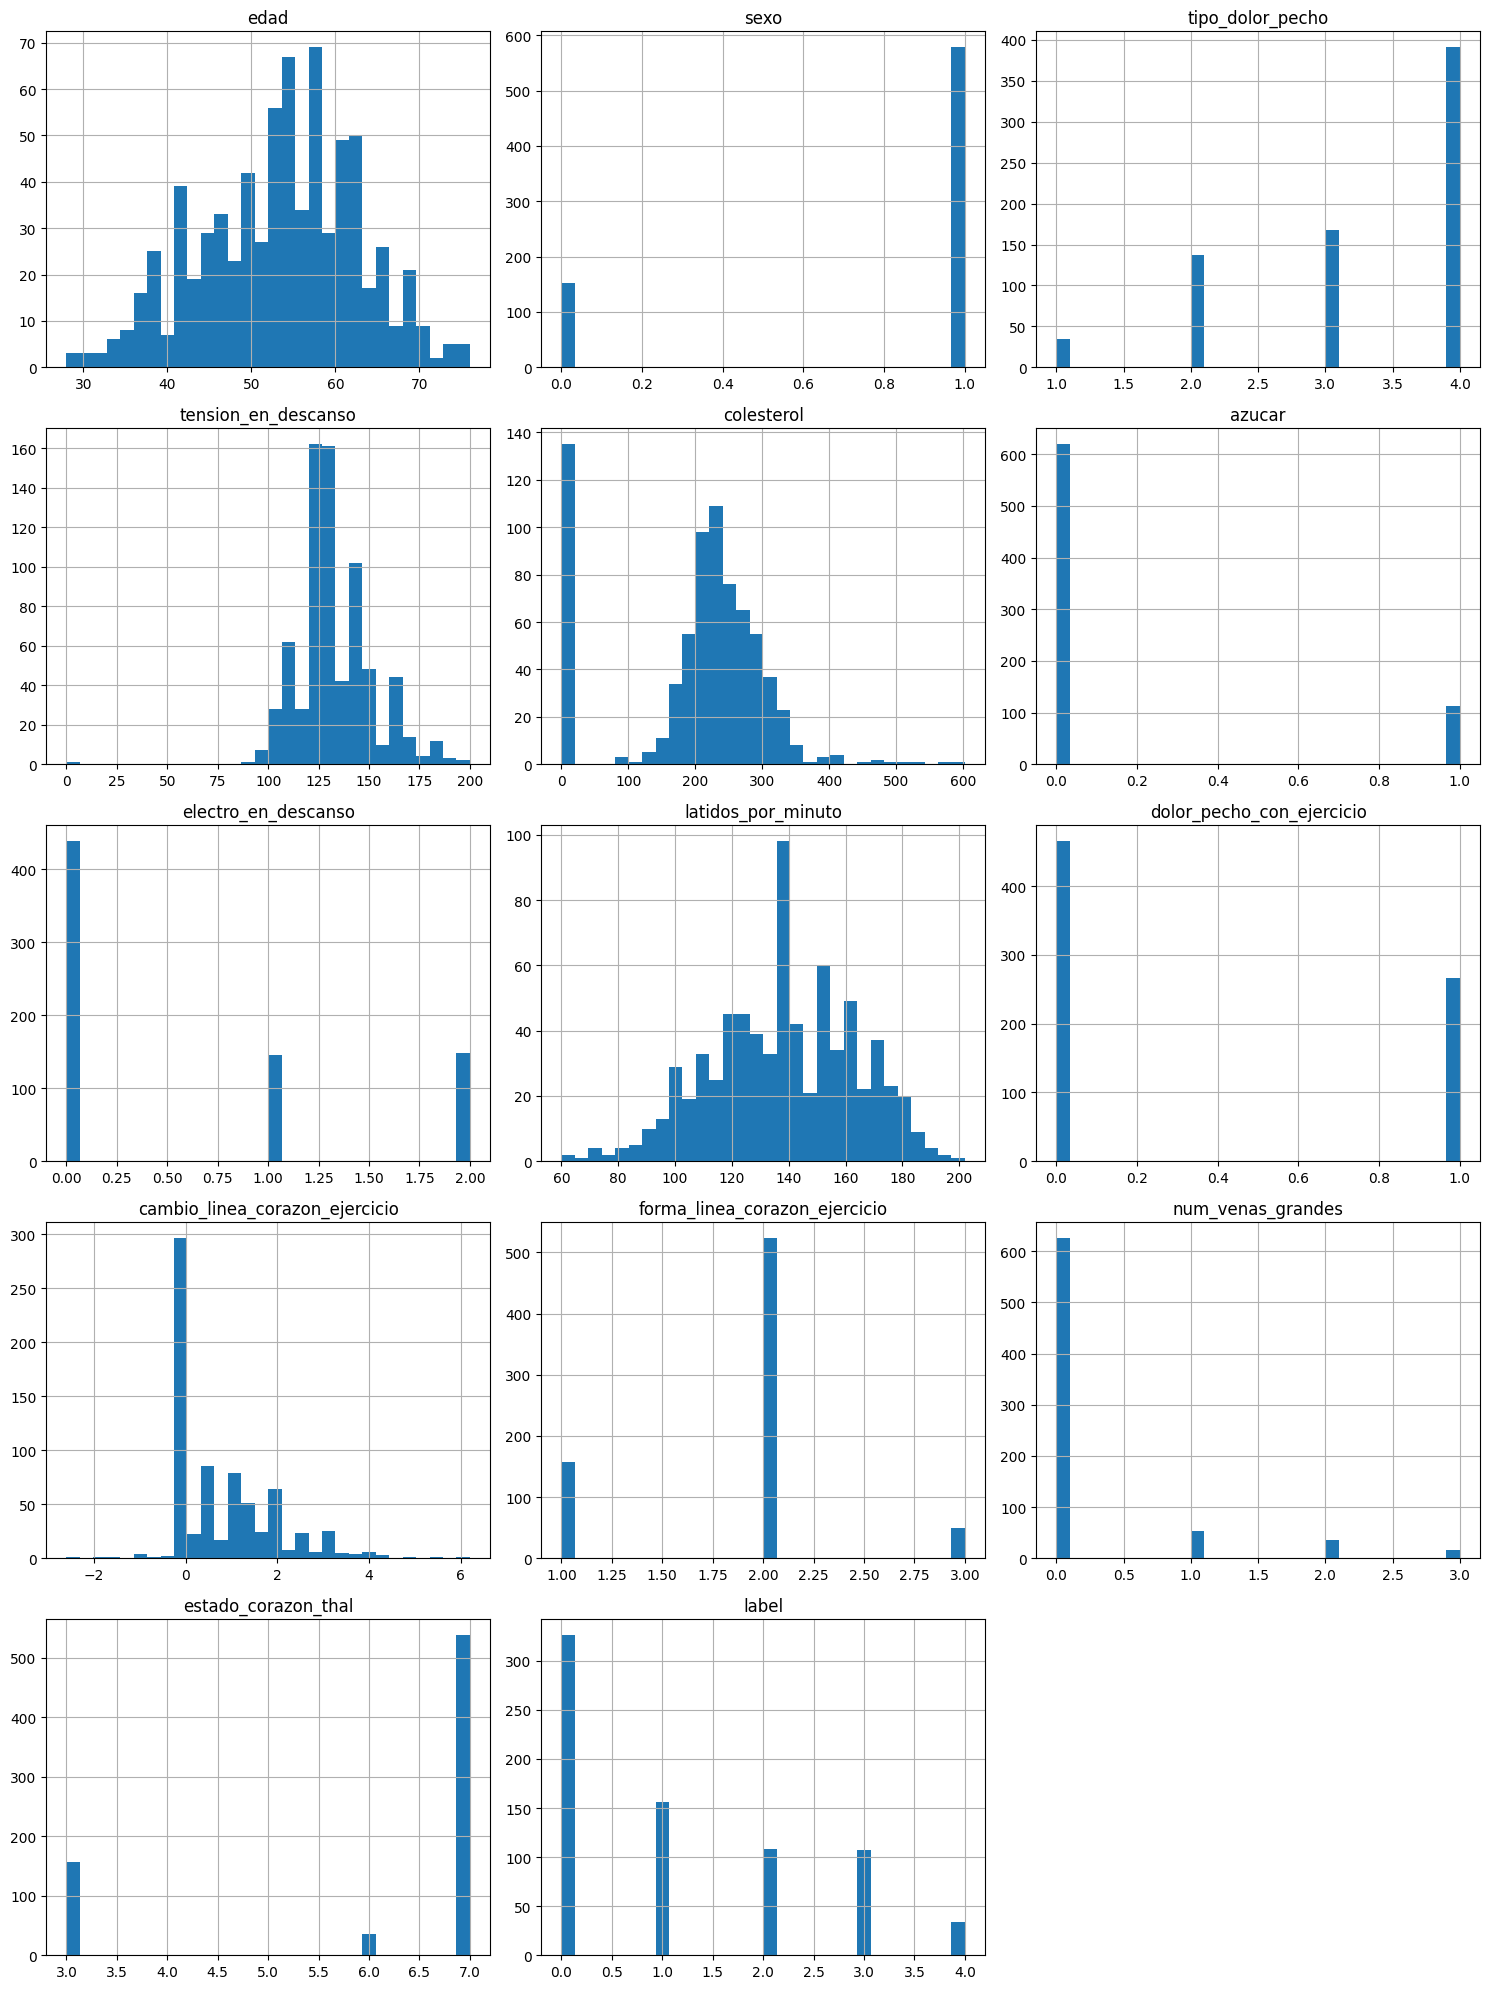

In [ ]:

#Histogramas
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

n = len(num_cols)
n_cols = 3  # nº de gráficos por fila
n_rows = math.ceil(n / n_cols)

plt.figure(figsize=(5*n_cols, 4*n_rows))

for i, c in enumerate(num_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    df[c].hist(bins=30)
    plt.title(c)

plt.tight_layout()
plt.show()



In [ ]:
df.describe()

,edad,sexo,tipo_dolor_pecho,tension_en_descanso,colesterol,azucar,electro_en_descanso,latidos_por_minuto,dolor_pecho_con_ejercicio,cambio_linea_corazon_ejercicio,forma_linea_corazon_ejercicio,num_venas_grandes,estado_corazon_thal,label
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,53.370725,0.790698,3.251710,131.878249,200.586867,0.153215,0.603283,138.214774,0.363885,0.856908,1.852257,0.239398,6.091655,1.134063
std,9.311838,0.407089,0.922835,18.577131,109.463168,0.360441,0.803206,25.178195,0.481446,1.079506,0.512907,0.646492,1.632235,1.257777
min,28.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,1.000000,0.000000,3.000000,0.000000
25%,47.000000,1.000000,3.000000,120.000000,177.500000,0.000000,0.000000,120.000000,0.000000,0.000000,2.000000,0.000000,6.000000,0.000000
50%,54.000000,1.000000,4.000000,130.000000,223.000000,0.000000,0.000000,140.000000,0.000000,0.500000,2.000000,0.000000,7.000000,1.000000
75%,60.000000,1.000000,4.000000,140.000000,267.000000,0.000000,1.000000,156.500000,1.000000,1.500000,2.000000,0.000000,7.000000,2.000000
max,76.000000,1.000000,4.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


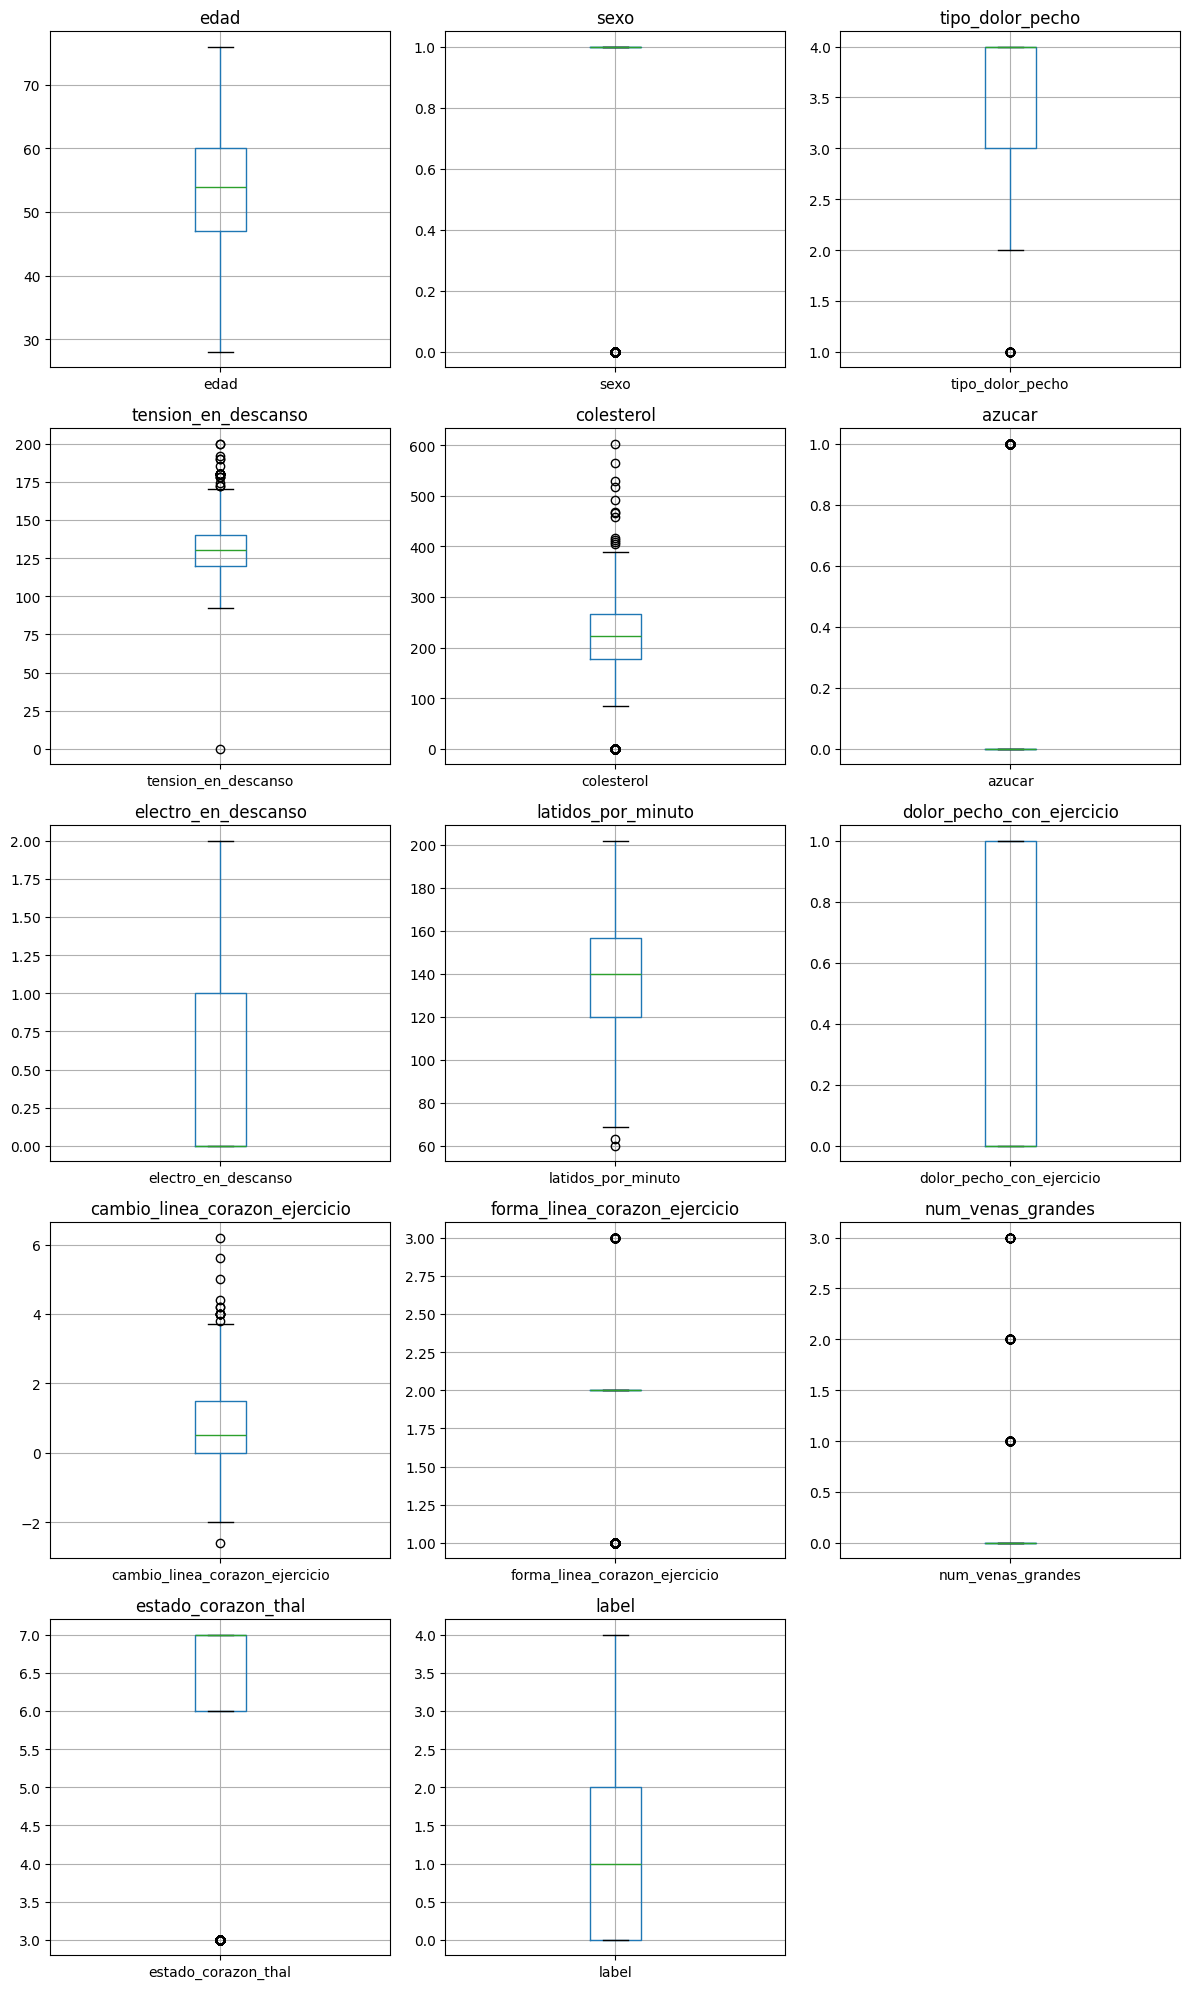

In [ ]:
#Boxplot

n = len(num_cols)
n_cols = 3
n_rows = math.ceil(n / n_cols)

plt.figure(figsize=(4*n_cols, 4*n_rows))

for i, c in enumerate(num_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    df.boxplot(column=c)
    plt.title(c)

plt.tight_layout()
plt.show()


Filtrado : B. Selección Automática:
Lasso (L1): Usar regularización fuerte para forzar coeficientes a cero y seleccionar variables automáticamente.
Tree-based Importance: Usar Random Forest para detectar variables no lineales que el ANOVA pudo subestimar.

In [ ]:
import pandas as pd

# 👉 CAMBIA ESTO por tu fichero y por tu target
RUTA_CSV = "test.csv"
TARGET_COL = "nombre_de_tu_target"  # ej: "price", "y", "target", etc.

# Cargar datos
df = pd.read_csv(RUTA_CSV)

# Separar X (features) e y (target)
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]


FileNotFoundError: [Errno 2] No such file or directory: 'test.csv'

In [ ]:
# Creamos el split
y = df['label']                 # lo que quieres predecir
X = df.drop(columns=['label'])  # todas las columnas excepto la etiqueta

# 1. Train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# 2. Pipeline: escalado + modelo
modelo = Pipeline([
    ('scaler', StandardScaler()),              # si todas son numéricas
    ('clf', LogisticRegression(max_iter=1000))
])


In [ ]:
modelo.fit(X_train, y_train)
#Ajustar el UMBRAL de probabilidad

y_val_proba = modelo.predict_proba(X_test)[:, 1]  # prob de clase 1
#umbrales = np.linspace(0.1, 0.9, 17)
umbrales = np.linspace(0.10, 1, 100)

mejor_f1 = 0
mejor_umbral = 0.5

for t in umbrales:
    y_val_pred_t = (y_val_proba >= t).astype(int)
    f1_t = f1_score(y_test, y_val_pred_t, average='weighted')
    print(f"Umbral {t:.2f} -> F1 = {f1_t:.4f}")
    if f1_t > mejor_f1:
        mejor_f1 = f1_t
        mejor_umbral = t

print("Mejor umbral:", mejor_umbral, "con F1 =", mejor_f1)
UMBRAL = mejor_umbral

Umbral 0.10 -> F1 = 0.3651
Umbral 0.11 -> F1 = 0.3772
Umbral 0.12 -> F1 = 0.3896
Umbral 0.13 -> F1 = 0.3878
Umbral 0.14 -> F1 = 0.4045
Umbral 0.15 -> F1 = 0.3975
Umbral 0.15 -> F1 = 0.3959
Umbral 0.16 -> F1 = 0.3942
Umbral 0.17 -> F1 = 0.3993
Umbral 0.18 -> F1 = 0.3959
Umbral 0.19 -> F1 = 0.3959
Umbral 0.20 -> F1 = 0.4003
Umbral 0.21 -> F1 = 0.4003
Umbral 0.22 -> F1 = 0.3989
Umbral 0.23 -> F1 = 0.3948
Umbral 0.24 -> F1 = 0.3977
Umbral 0.25 -> F1 = 0.3840
Umbral 0.25 -> F1 = 0.3759
Umbral 0.26 -> F1 = 0.3688
Umbral 0.27 -> F1 = 0.3859
Umbral 0.28 -> F1 = 0.3822
Umbral 0.29 -> F1 = 0.3783
Umbral 0.30 -> F1 = 0.3716
Umbral 0.31 -> F1 = 0.3647
Umbral 0.32 -> F1 = 0.3520
Umbral 0.33 -> F1 = 0.3505
Umbral 0.34 -> F1 = 0.3490
Umbral 0.35 -> F1 = 0.3533
Umbral 0.35 -> F1 = 0.3273
Umbral 0.36 -> F1 = 0.3258
Umbral 0.37 -> F1 = 0.3245
Umbral 0.38 -> F1 = 0.3153
Umbral 0.39 -> F1 = 0.3146
Umbral 0.40 -> F1 = 0.3185
Umbral 0.41 -> F1 = 0.3179
Umbral 0.42 -> F1 = 0.3079
Umbral 0.43 -> F1 = 0.3102
U

In [ ]:


# 3. Entrenamiento
modelo.fit(X_train, y_train)

# 4. Predicciones
y_pred = modelo.predict(X_test)

y_test_proba = modelo.predict_proba(X_test)[:, 1]
y_pred_Umbral = (y_test_proba >= UMBRAL).astype(int)


# 5. F1 (ajusta average según tu caso)
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 score:", f1)
print(classification_report(y_test, y_pred))

f1_Umbral = f1_score(y_test, y_pred_Umbral, average='weighted')
print("F1 score umbral:", f1_Umbral)
print(classification_report(y_test, y_pred_Umbral))

F1 score: 0.47317230418536904
              precision    recall  f1-score   support

           0       0.72      0.89      0.80        66
           1       0.24      0.29      0.26        31
           2       0.29      0.09      0.14        22
           3       0.25      0.19      0.22        21
           4       0.25      0.14      0.18         7

    accuracy                           0.51       147
   macro avg       0.35      0.32      0.32       147
weighted avg       0.46      0.51      0.47       147

F1 score umbral: 0.4045486769591933
              precision    recall  f1-score   support

           0       0.75      0.65      0.70        66
           1       0.29      0.84      0.43        31
           2       0.00      0.00      0.00        22
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00         7

    accuracy                           0.47       147
   macro avg       0.21      0.30      0.23       147
weighted av

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Re-create the train/test split to ensure X_test and y_test are consistent
X_train_mlp, X_test_mlp, y_train_mlp, y_test_mlp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

mlp = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', MLPClassifier(
        hidden_layer_sizes=(32, 16),
        activation='relu',
        solver='adam',
        alpha=1e-2,          # un poco más de regularización
        max_iter=1000,
        early_stopping=True, # para que pare solo
        n_iter_no_change=20,
        random_state=42
    ))
])

mlp.fit(X_train_mlp, y_train_mlp)
y_pred_mlp = mlp.predict(X_test_mlp)
print("F1 MLP (weighted):", f1_score(y_test_mlp, y_pred_mlp, average='weighted'))
print(classification_report(y_test_mlp, y_pred_mlp))


F1 MLP (weighted): 0.4450545921644188
              precision    recall  f1-score   support

           0       0.58      0.94      0.72        66
           1       0.28      0.23      0.25        31
           2       0.50      0.18      0.27        22
           3       0.43      0.14      0.21        21
           4       0.00      0.00      0.00         7

    accuracy                           0.52       147
   macro avg       0.36      0.30      0.29       147
weighted avg       0.46      0.52      0.45       147



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# 1. Cargar test y sample_submission
test = pd.read_csv("/content/drive/MyDrive/IA PROJECT 1/csv/CSV's genericos/test.csv")
submission = pd.read_csv("/content/drive/MyDrive/IA PROJECT 1/csv/CSV's genericos/sample_submission.csv")

test = test.rename(columns={
    "age": "edad",
    "sex": "sexo",
    "cp": "tipo_dolor_pecho",
    "trestbps": "tension_en_descanso",
    "chol": "colesterol",
    "fbs": "azucar",
    "restecg": "electro_en_descanso",
    "thalach": "latidos_por_minuto",
    "exang": "dolor_pecho_con_ejercicio",
    "oldpeak": "cambio_linea_corazon_ejercicio",
    "slope": "forma_linea_corazon_ejercicio",
    "ca": "num_venas_grandes",
    "thal": "estado_corazon_thal"
})

# 2. Reemplazar '?' por NaN
test = test.replace('?', np.nan)

# 3. Convertir todas las columnas a numéricas (en este dataset todas lo son)
for col in test.columns:
    test[col] = pd.to_numeric(test[col], errors='coerce')

# Re-define X and y for training to ensure 'modelo' can be trained within this cell
y = df['label']                 # lo que quieres predecir
X = df.drop(columns=['label'])  # todas las columnas excepto la etiqueta

# Create the train/test split for training the model
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Define the pipeline (modelo)
modelo = Pipeline([
    ('scaler', StandardScaler()),              # si todas son numéricas
    ('clf', LogisticRegression(max_iter=1000))
])

# Train the model
modelo.fit(X_train, y_train)

# Now, proceed with the test set preprocessing and prediction

# 4. Imputar nulos del test usando la MEDIANA DEL TRAIN (muy importante, no del test)
FEATURE_COLS = X.columns  # X = train.drop(columns=['label']) que usaste para entrenar

for col in FEATURE_COLS:
    mediana_train = X[col].median()
    test[col] = test[col].fillna(mediana_train)

# 5. Construir X_test con las mismas columnas que usaste para entrenar
X_test_final = test[FEATURE_COLS]

# 6. Ahora sí: predecir
y_test_pred = modelo.predict(X_test_final)
print(len(y_test_pred))  # debería ser 184

print("Filas test:", len(test))
print("Filas sample_submission:", len(submission))

# 4. Crear submission: misma estructura que sample_submission,
#    solo cambiamos la columna 'label'
submission["label"] = y_test_pred

# 5. Guardar CSV final
submission.to_csv("submission.csv", index=False)

184
Filas test: 184
Filas sample_submission: 184


In [ ]:
import pandas as pd
from google.colab import files

# Supongamos que tu DataFrame se llama df
df.to_csv("mi_dataset_limpio.csv", index=False)

files.download("mi_dataset_limpio.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>